In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
import mmap
from pathlib import Path

%matplotlib widget

# mmap activated to not store everything in memory

"""def other_mmap(filename, shape, dtype, chunks):
    with open(filename, "rb") as fh:
        # `mmap` duplicates the file descriptor
        # `0` means map the full file
        mm = mmap.mmap(fh.fileno(), 0, access=mmap.ACCESS_READ)

    # coerce to NumPy array of expected type and shape
    a = np.asarray(mm).view(dtype).reshape(shape)

    # Don't call `asarray`
    # name=False to avoid hashing
    a_d = da.from_array(a, chunks=chunks, asarray=False, name=False)
    return a_d"""

folder_base = Path('C:/Users/AudreyHay/Desktop/fusion 20 février python')
#folder_base = Path('/mnt/data/ahay/')
filename = folder_base / f'RawDataChannelExtractedDS2.npy'
All = np.load(filename, mmap_mode= 'r')

All = All.T #?
EMG = All[:,22] #Femelle: 58 - 32 = 26 // 0 based : 26-1 = 25 /// Mâle: 0 based uniquement (écrire 22)
HIP = All[:,30] #Mâle : écrire 30 // femelle : hippocampe : 33 + 62 à 64 ( 63-32 = 31 ; 0 based = 30) écrire 30


In [2]:

# Filter parameter :
f_lowcut = 200.
f_hicut = 400.
N = 4
fs = 1000
nyq = 0.5 * fs
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction


# Filter creation :
b, a = signal.butter(N, Wn, 'band')
filt_EMG = signal.filtfilt(b, a, EMG)


# Filter parameter :
f_lowcut = 0.5
f_hicut = 30.
N = 4
fs = 1000
nyq = 0.5 * fs
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction


# Filter creation :
b, a = signal.butter(N, Wn, 'band')
filt_HIP = signal.filtfilt(b, a, HIP)


C:\Users\AudreyHay\AppData\Local\Temp\ipykernel_20240\2984205880.py:9: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  EMGcwt = signal.cwt(EMG, signal.morlet2, widths, w=w)


Nombre de transitions de 0 à 1 : 127
Nombre de transitions de 1 à 2 : 58
Nombre de transitions de 2 à 1 : 58
Nombre de transitions de 1 à 0 : 126
Durée de l'état 0 : 20875040 ms
Durée de l'état 1 : 286869 ms
Durée de l'état 2 : 177867 ms


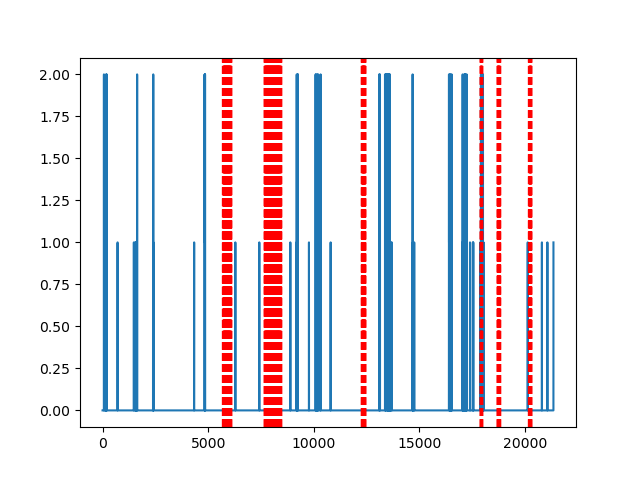

Text(0.5, 1.0, 'Mâle 5 kHz son faible')

In [3]:

# Plot
times = np.arange(0, EMG.size/fs, 1./fs)
timesmin = np.arange(0, EMG.size/fs/60, 1./fs/60)

# Parameter and computation of CWT
w = 4.
freq = np.linspace(200, 400, 50)
widths = w*fs / (2*freq*np.pi)
EMGcwt = signal.cwt(EMG, signal.morlet2, widths, w=w)

# Projection calculation
absEMGcwt = np.absolute(EMGcwt)
proj_EMGcwt = np.sum(absEMGcwt, axis = 0)/50
sdproj_EMGcwt = np.std(proj_EMGcwt)
sd3proj_EMGcwt = sdproj_EMGcwt*40
sd05proj_EMGcwt = sdproj_EMGcwt*15

start = 00000
end = 100000000

tt = times[start:end]
EMGt = EMG[start:end]
EMGcwtt = EMGcwt[:, start:end]
proj_EMGcwtt = proj_EMGcwt[start:end]

# Assigning values wake (1, 2) and sleep (0)
# 1 = eveil calme // 2 = eveil énergique
numpnts = EMG.size
EMGstatusRaw = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_EMGcwt[ind]<sd05proj_EMGcwt:
        EMGstatusRaw[ind] = 0
    elif proj_EMGcwt[ind]>sd3proj_EMGcwt:
        EMGstatusRaw[ind] = 2
    else: 
        EMGstatusRaw[ind] = 1

# Expanding borders for wake (1, 2) and sleep (0) to ±1 s around detected muscular activity
EMGstatusRaw2 = np.zeros(numpnts)
for ind in range(numpnts):
    if EMGstatusRaw[ind]>1:
       EMGstatusRaw2[ind-1000:ind+1000] = 2
    elif EMGstatusRaw[ind]==1:
        for ind2 in range(ind-1000, ind+1000):
            if ind2==numpnts:
                break
            elif EMGstatusRaw2[ind2]<2:
                EMGstatusRaw2[ind2] = 1

transitions_0_to_1 = 0
transitions_1_to_2 = 0
transitions_2_to_1 = 0
transitions_1_to_0 = 0

# Compter les transitions
for i in range(1, len(EMGstatusRaw2)):
    if EMGstatusRaw2[i-1] == 0 and EMGstatusRaw2[i] == 1:
        transitions_0_to_1 += 1
    elif EMGstatusRaw2[i-1] == 1 and EMGstatusRaw2[i] == 2:
        transitions_1_to_2 += 1
    elif EMGstatusRaw2[i-1] == 2 and EMGstatusRaw2[i] == 1:
        transitions_2_to_1 += 1
    elif EMGstatusRaw2[i-1] == 1 and EMGstatusRaw2[i] == 0:
        transitions_1_to_0 += 1

# Afficher les résultats
print("Nombre de transitions de 0 à 1 :", transitions_0_to_1)
print("Nombre de transitions de 1 à 2 :", transitions_1_to_2)
print("Nombre de transitions de 2 à 1 :", transitions_2_to_1)
print("Nombre de transitions de 1 à 0 :", transitions_1_to_0)
#0 = sommeil // 1 = éveil très calme // 2 = éveil énergique

# Calcul de la durée des états
duree_etat_0 = np.sum(EMGstatusRaw2 == 0)
duree_etat_1 = np.sum(EMGstatusRaw2 == 1)
duree_etat_2 = np.sum(EMGstatusRaw2 == 2)

# Affichage des durées
print("Durée de l'état 0 :", duree_etat_0, "ms")
print("Durée de l'état 1 :", duree_etat_1, "ms")
print("Durée de l'état 2 :", duree_etat_2, "ms")

# Charger les timestamps des stimulations
ttl = np.load("C:/Users/AudreyHay/Desktop/fusion 20 février python/timestamps_20_fev.npy")
#ttl2 = np.load("C:/Users/AudreyHay/Desktop/openephys/2024-02-20_14-31-33/Record Node 103/experiment1/recording1/events/Acquisition_Board-100.Rhythm Data/TTL/timestamps.npy")
# print(ttl)
ttl = ttl#/60

fig, ax = plt.subplots()
#ax.plot(timesmin[:22000*fs], filt_EMG[:22000*fs])
ax.plot(tt, EMGstatusRaw2)

# Ajouter des traits verticaux pour chaque timestamp de stimulation
for timestamp in ttl:
    ax.axvline(x=timestamp, color='r', linestyle='--')
    pass

#for timestamp in ttl2 (pour enregistrement fragmenté):
#     ax.axvline(x=timestamp, color='r', linestyle='--')
#     pass

plt.show()
titre = "Mâle 5 kHz son faible" # changer le titre ici
plt.title(titre)

In [4]:
plt.close()

Échec pour le timestamp 8384.407 (longueur des données = 10001)


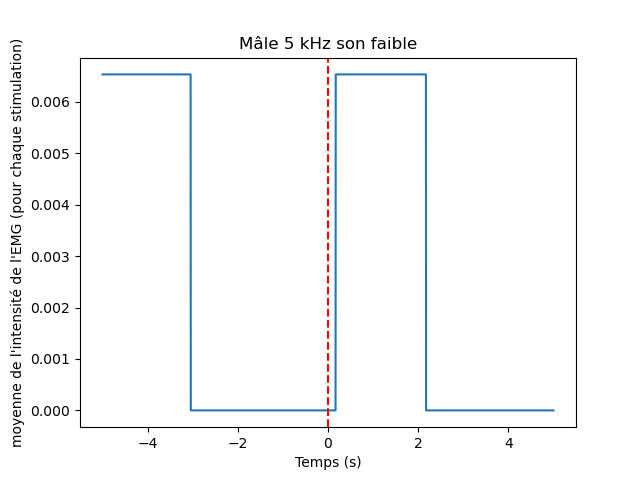

In [6]:
# fs = 1000

# fig, ax = plt.subplots()
# # ax.plot(timesmin[:22000*fs], filt_EMG[:22000*fs])
# # ax.plot(tt, EMGstatusRaw2)
# duration=5 #seconds

# tt2 = np.arange(-duration,duration,1/fs)
# avg = np.zeros(tt2.shape)
# # Ajouter des traits verticaux pour chaque timestamp de stimulation
# for i in range(int(ttl.shape[0]/2)):
#     timestamp = ttl[int(i*2)]
    
#     avg += EMGstatusRaw2[int((timestamp-duration)*fs):int((timestamp+duration)*fs)]

# avg /= int(ttl.shape[0]/2)
# ax.plot(tt2,avg)
# ax.axvline(x=0, color='r', linestyle='--')

# plt.title(titre)
# plt.xlabel("Temps (s)")
# plt.ylabel("moyenne de l'intensité de l'EMG (pour chaque stimulation)")
# plt.show()

fs = 1000
fig, ax = plt.subplots()

duration = 5  # seconds
tt2 = np.arange(-duration, duration, 1/fs)
avg = np.zeros(len(tt2))

# Ajouter des traits verticaux pour chaque timestamp de stimulation
for i in range(int(ttl.shape[0]//2)):
    timestamp = ttl[int(i*2)]
    start_idx = int((timestamp - duration) * fs)
    end_idx = int((timestamp + duration) * fs)

    # Extraire les données correspondantes de EMGstatusRaw2
    data = EMGstatusRaw2[start_idx:end_idx]
    
    # Vérifier que la longueur des données extraites correspond à tt2
    if len(data) == len(tt2):
        avg += data
    else:
        print(f"Échec pour le timestamp {timestamp} (longueur des données = {len(data)})")

avg /= int(ttl.shape[0]//2)
ax.plot(tt2, avg)
ax.axvline(x=0, color='r', linestyle='--')
plt.title(titre)
plt.xlabel("Temps (s)")
plt.ylabel("moyenne de l'intensité de l'EMG (pour chaque stimulation)")
plt.show()

Échec pour le timestamp 8384.407 (longueur du segment = 10001)


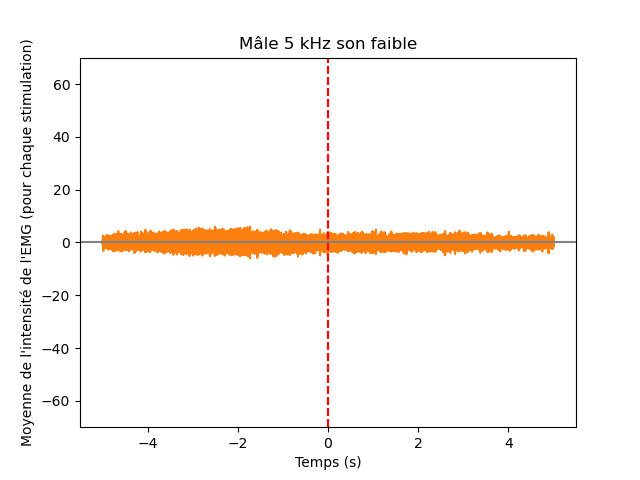

In [7]:
plt.close()

duration = 5  # Durée de la fenêtre autour de chaque stimulus en secondes
num_trials = int(ttl.shape[0] / 2)  # Nombre de stimuli

# Créer un vecteur de temps pour la période autour de chaque stimulus
tt2 = np.arange(-duration, duration, 1/fs)

# Initialiser un tableau pour stocker les ERP
erp = np.zeros(len(tt2), dtype=np.complex128)

# Boucler à travers chaque stimulus et calculer l'ERP
for i in range(num_trials):
    timestamp = ttl[int(i * 2)]
    start_idx = int((timestamp - duration) * fs)
    end_idx = int((timestamp + duration) * fs)

    # Vérifier que la taille du segment extrait correspond à len(tt2)
    segment = filt_EMG[start_idx:end_idx]
    if len(segment) == len(tt2):
        erp += segment
    else:
        print(f"Échec pour le timestamp {timestamp} (longueur du segment = {len(segment)})")

erp = np.real(erp)

# Calculer la moyenne des ERP
erp /= num_trials

# Tracer l'ERP
plt.plot(tt2, erp, color='#ff7f0e')
plt.axvline(x=0, color='r', linestyle='--')
plt.title(titre)
plt.axhline(y=0, color='grey', linestyle='-')
plt.xlabel("Temps (s)")
plt.ylabel("Moyenne de l'intensité de l'EMG (pour chaque stimulation)")
plt.ylim(-70, 70)  # Définir les limites de l'axe des y
plt.show()


Taille de segment incorrecte pour le timestamp 8384.407


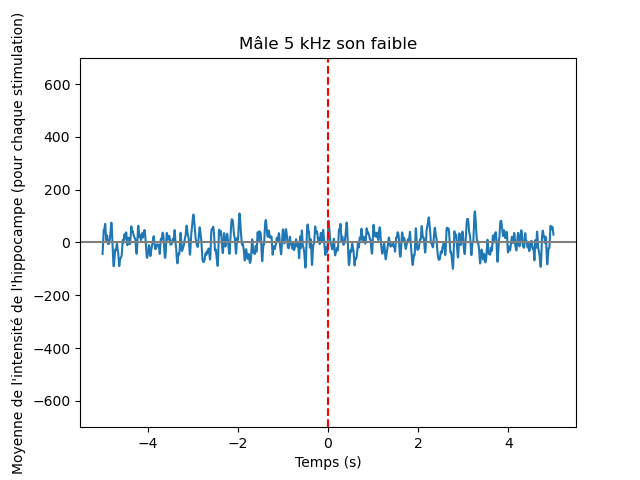

In [8]:
plt.close()

duration = 5
num_trials = int(ttl.shape[0] / 2)
tt2 = np.arange(-duration, duration, 1/fs)
erp2 = np.zeros(len(tt2), dtype=np.complex128)

for i in range(num_trials):
    timestamp = ttl[int(i * 2)]
    start_idx = int((timestamp - duration) * fs)
    end_idx = int((timestamp + duration) * fs)
    
    # Vérifier que les indices ne sont pas négatifs
    if start_idx >= 0 and end_idx >= 0:
        segment = filt_HIP[start_idx:end_idx]
        
        # Vérifier que la taille du segment correspond à la taille de erp2
        if len(segment) == len(erp2):
            erp2 += segment
        else:
            print(f"Taille de segment incorrecte pour le timestamp {timestamp}")
    else:
        print(f"Indices négatifs pour le timestamp {timestamp}")

erp2 = np.real(erp2)
erp2 /= num_trials

# Tracer l'ERP
plt.plot(tt2, erp2, color='#1f77b4')
plt.axvline(x=0, color='r', linestyle='--')
plt.title(titre)
plt.xlabel("Temps (s)")
plt.axhline(y=0, color='grey', linestyle='-')
plt.ylabel("Moyenne de l'intensité de l'hippocampe (pour chaque stimulation)")
plt.ylim(-700, 700) 
plt.show()

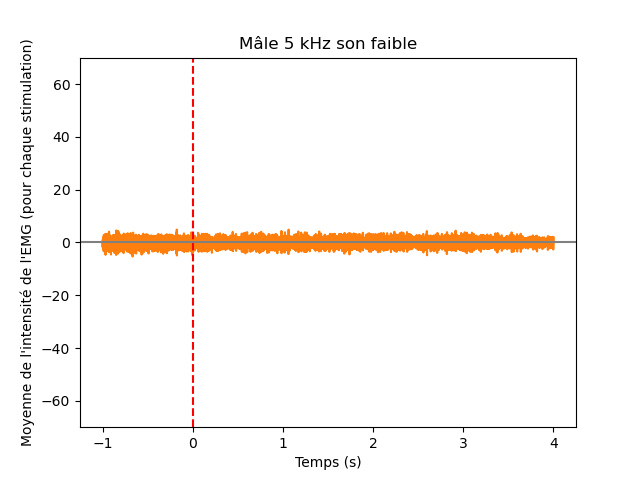

In [9]:
# -1s et +4s après le stimulus
plt.close()

duration_before = 1  # Durée avant le stimulus en secondes
duration_after = 4   # Durée après le stimulus en secondes
duration_total = duration_before + duration_after  # Durée totale de la fenêtre

num_trials = int(ttl.shape[0] / 2)  # Nombre de stimuli

# Créer un vecteur de temps pour la période autour de chaque stimulus
tt2 = np.arange(-duration_before, duration_after + 1/fs, 1/fs)  # +1/fs pour inclure la dernière valeur

# Initialiser un tableau pour stocker les ERP
erp = np.zeros(len(tt2), dtype=np.complex128)

# Boucler à travers chaque stimulus et calculer l'ERP
for i in range(num_trials):
    timestamp = ttl[int(i * 2)]
    start_idx = int((timestamp - duration_before) * fs)
    end_idx = int((timestamp + duration_after) * fs)

    segment = filt_EMG[start_idx:end_idx+1]  # +1 pour inclure la dernière valeur
    
    # Vérifier que la taille du segment n'est pas nulle
    if len(segment) > 0:
        erp += segment
    else:
        print(f"Segment vide pour le timestamp {timestamp}")

erp = np.real(erp)

# Calculer la moyenne des ERP
erp /= num_trials

# Tracer l'ERP
plt.plot(tt2, erp, color='#ff7f0e')
plt.axvline(x=0, color='r', linestyle='--')
plt.title(titre)
plt.axhline(y=0, color='grey', linestyle='-')
plt.xlabel("Temps (s)")
plt.ylabel("Moyenne de l'intensité de l'EMG (pour chaque stimulation)")
plt.ylim(-70, 70) 
plt.show()

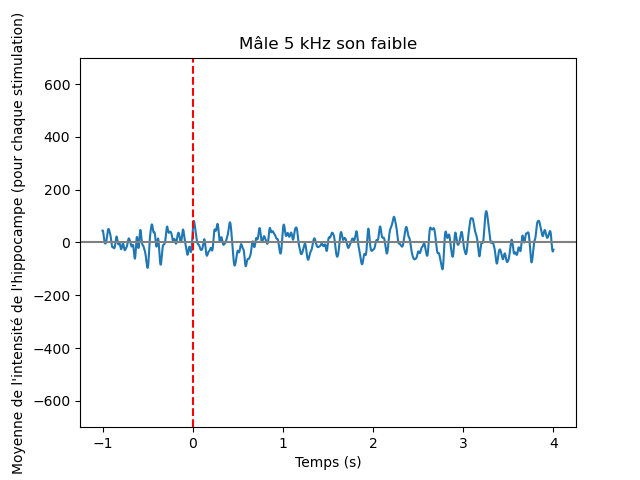

In [17]:
# fenêtre -1s à +4s hippocampe
plt.close()

duration_before = 1  # Durée avant le stimulus en secondes
duration_after = 4   # Durée après le stimulus en secondes
duration_total = duration_before + duration_after  # Durée totale de la fenêtre
num_trials = int(ttl.shape[0] / 2)  # Nombre de stimuli

# Créer un vecteur de temps pour la période autour de chaque stimulus
tt2 = np.arange(-duration_before, duration_after + 1/fs, 1/fs)  # +1/fs pour inclure la dernière valeur

# Initialiser un tableau pour stocker les ERP
erp2 = np.zeros((len(tt2),0), dtype=np.complex128)

# Boucler à travers chaque stimulus et calculer l'ERP
for i in range(num_trials):
    timestamp = ttl[int(i * 2)]
    start_idx = int((timestamp - duration_before) * fs)
    end_idx = int((timestamp + duration_after) * fs)

    segment = np.array(filt_HIP[start_idx:end_idx+1, np.newaxis])  # +1 pour inclure la dernière valeur
     
    # Vérifier que la taille du segment n'est pas nulle
    if len(segment) > 0:
        erp2 = np.append(erp2,segment,axis=1)
    else:
        print(f"Segment vide pour le timestamp {timestamp}")

erp2 = np.real(erp2)

# Calculer la moyenne des ERP
#erp2 /= num_trials

# Tracer l'ERP
plt.plot(tt2, np.mean(erp2, axis = 1), color='#1f77b4')
plt.axvline(x=0, color='r', linestyle='--')
plt.title(titre)
plt.xlabel("Temps (s)")
plt.axhline(y=0, color='grey', linestyle='-')
plt.ylabel("Moyenne de l'intensité de l'hippocampe (pour chaque stimulation)")
plt.ylim(-700, 700) 
plt.show()
